# Techniques of High Performance Computing - Assignment 4

**Name: John Duffy**

**Student Number: 19154676**

# In the Moment of Heat

Reference: The SIAM 100-Digit Challenge: A Study in High-Accuracy Numerical Computing / Folkmar Bourneman ... \[et al.\].

## Program Description

## Program Structure

## Correctness Testing

## Performance Testing

In [57]:
# Import libraries common to all implementations...

import numpy as np
import time

In [58]:
# declare a utility array plotting function...

import matplotlib.pyplot as plt

def plot(u):
    plt.figure(figsize=(8, 6))
    plt.imshow(u, origin='lower', extent=(-1, 1, -1, 1), cmap='Reds')
    plt.colorbar()
    plt.show()

In [59]:
# Declare a useful timer class...

class Timer:
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

## Finite Differences

In [60]:
# Import numba...

from numba import njit, prange

### CD_SPACE_FE_TIME_V0

In [61]:
@njit(parallel=True)
def step(n, u, c):
    '''
    This function
    '''
    v = np.copy(u)
    for row in range(1, n - 1):
        for col in prange(1, n - 1):
            v[row, col] = u[row, col] - c * (4 * u[row, col] - u[row - 1, col] - u[row + 1, col] - u[row, col - 1] - u[row, col + 1])

    return v

CD_SPACE_FE_TIME_V0
N: 101
M: 10001
C: 0.25
T: 0.424
Total time: 2.585007667541504


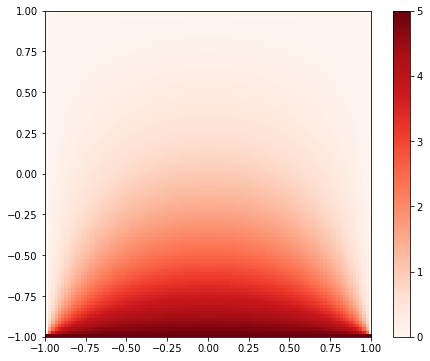

In [62]:
N = 101
M = 10001

print("CD_SPACE_FE_TIME_V0")
print("N: {}".format(N))
print("M: {}".format(M))
print("C: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))

u = np.zeros((N, N), dtype=np.float64)

u[0, :] = 5.0

h = 2.0 / (N - 1)
k = 1.0 / (M - 1)

c = k / h**2

i = 0

with Timer() as t:
    
    while u[(N - 1) // 2, (N - 1) // 2] < 1.0:
        u = step(N, u, c)
        i = i + 1
    
print("T: {}".format(i / (M - 1)))
print("Total time: {0}".format(t.interval))

plot(u)

### CD_TIME_FE_SPACE_V1

CD_SPACE_FE_TIME_V1
N: 101
M: 10001
C: 0.25
T: 0.424
Total time: 0.40648484230041504


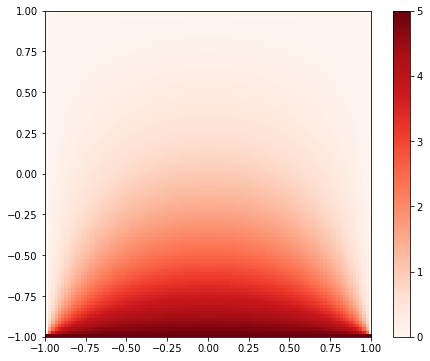

In [63]:
N = 101
M = 10001

print("CD_SPACE_FE_TIME_V1")
print("N: {}".format(N))
print("M: {}".format(M))
print("C: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))

u = np.zeros((N, N), dtype=np.float64)

u[0, :] = 5.0

i = 0

with Timer() as t:
    
    while u[(N - 1) // 2, (N - 1) // 2] < 1.0:
        u[1:N-1, 1:N-1] = u[1:N-1, 1:N-1] + (u[0:N-2, 1:N-1] + u[2:N, 1:N-1] + u[1:N-1, 0:N-2] + u[1:N-1, 2:N] - 4 * u[1:N-1, 1:N-1]) * (N - 1) * (N - 1) / 4 / (M - 1)
        i = i + 1
    
print("T: {}".format(i / (M - 1)))
print("Total time: {0}".format(t.interval))

plot(u)

### CD_TIME_FE_SPACE_V2

CD_SPACE_FE_TIME_V2
N: 101
M: 10001
C: 0.25
T: 0.424
Total time: 0.4221000671386719


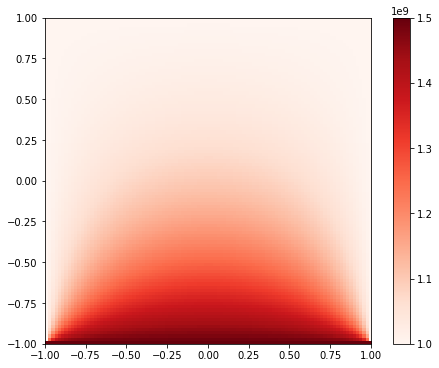

In [64]:
N = 101
M = 10001

print("CD_SPACE_FE_TIME_V2")
print("N: {}".format(N))
print("M: {}".format(M))
print("C: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))

u = np.full((N, N), 1_000_000_000, dtype=np.int64)

u[0, :] = 1_500_000_000

i = 0

with Timer() as t:    
    while u[(N - 1) // 2, (N - 1) // 2] < 1_100_000_000:
        u[1:N-1, 1:N-1] = u[1:N-1, 1:N-1] + (u[0:N-2, 1:N-1] + u[2:N, 1:N-1] + u[1:N-1, 0:N-2] + u[1:N-1, 2:N] - 4 * u[1:N-1, 1:N-1]) * (N - 1) * (N - 1) / 4 / (M - 1)
        i = i + 1
    
print("T: {}".format(i / (M - 1)))
print("Total time: {}".format(t.interval))

plot(u)

## CD_SPACE_FE_TIME_OPENCL_V0

In [65]:
import pyopencl as cl

In [66]:
# Define the OpenCL kernel string used in the class FiniteDifference. It is defined here outside
# of the class for readability, and also so that it may be developed/debugged externally and
# easily included here as part of a build system.

kernel_string = """

__kernel void cd_space_fe_time_opencl_v0(const int n, const int m, __global float *u, __global float *v, __global float *temperature)
{
    // Retrieve the row and column indexes from the global id's.
    
    int r = get_global_id(0);
    int c = get_global_id(1);
    
    // Implement the finite difference scheme for the interior points.
    
    if (r > 0 && r < n - 1 && c > 0 && c < n - 1) {
        v[n * r + c] = u[n * r + c] + \
            (u[n * (r - 1) + c] + u[n * (r + 1) + c] + u[n * r + (c - 1)] + u[n * r + (c + 1)] - 4.0f * u[n * r + c]) * (n - 1) * (n - 1) / 4.0f / (m - 1);
    }

    // Export the temperture of the centre of the plate.

    if (r == (n - 1) / 2 && c == (n - 1) / 2) {
        temperature[0] = u[n * r + c];
    }

    // Get ready for the next iteration by copying v to u
    
    u[n * r + c] = v[n * r + c];  
}

"""


# Define the class.

class CDSpaceFETimeOpenCLV0:
    """
    This class...
    """
    
    def __init__(self, n, m):
        
        # Store the n and m as instance variables for access by class methods.
        
        self._n = n
        self._m = m
               
        # Create a GPU specific context and command queue.
        
        self._ctx = cl.Context(dev_type = cl.device_type.GPU)
        
        self._queue = cl.CommandQueue(self._ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)
 
        # Create input and output buffers, u and v.
 
        self._u = cl.Buffer(self._ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.float32).itemsize * n * n)
        self._v = cl.Buffer(self._ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.float32).itemsize * n * n)
                
        # Create a buffer to hold the current temperature of the centre of the plate.
        
        self._temperature = cl.Buffer(self._ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.float32).itemsize)

        # Build the kernel.
        
        self._kernel = cl.Program(self._ctx, kernel_string).build().cd_space_fe_time_opencl_v0


    def copy_u_to_device(self, u):
        cl.enqueue_copy(self._queue, self._u, u)


    def copy_v_to_device(self, v):
        cl.enqueue_copy(self._queue, self._v, v)

        
    def copy_u_from_device(self):
        v = np.zeros((self._n, self._n), dtype=np.float32)
        cl.enqueue_copy(self._queue, u, self._u)            
        return v


    def copy_v_from_device(self):
        v = np.zeros((self._n, self._n), dtype=np.float32)
        cl.enqueue_copy(self._queue, v, self._v)            
        return v


    def copy_temperature_from_device(self):
        temperature = np.zeros((1), dtype=np.float32)
        cl.enqueue_copy(self._queue, temperature, self._temperature)            
        return temperature[0]

           
    def step(self):
        self._kernel(self._queue, (self._n, self._n), None,
                     np.int32(self._n),
                     np.int32(self._m),
                     self._u,
                     self._v,
                     self._temperature)

CD_SPACE_FE_TIME_OPENCL_V0
N: 101
M: 10001
C: 0.25
T: 0.4209
Total time: 1.3126170635223389


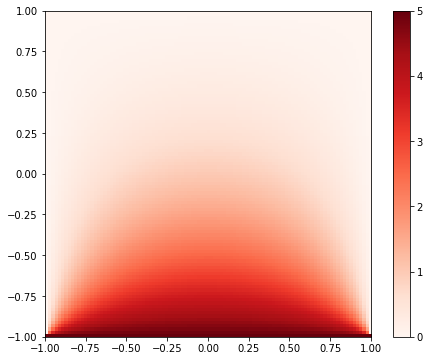

In [67]:
N = 101
M = 10001

print("CD_SPACE_FE_TIME_OPENCL_V0")
print("N: {}".format(N))
print("M: {}".format(M))
print("C: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))

u = np.zeros((N, N), dtype=np.float32)
v = np.zeros((N, N), dtype=np.float32)

u[0, :] = 5.0

finite_differences = CDSpaceFETimeOpenCLV0(N, M)

finite_differences.copy_u_to_device(u)
finite_differences.copy_v_to_device(u)

i = 0

with Timer() as t:
    
    while True:
        finite_differences.step()
        i = i + 1
        temperature = finite_differences.copy_temperature_from_device()
        if not temperature < 1.0:
            u = finite_differences.copy_v_from_device()            
            break

print("T: {}".format(i / (M - 1)))
print("Total time: {0}".format(t.interval))

plot(u)

## CD_SPACE_FE_TIME_OPENCL_V1

In [68]:
# Define the OpenCL kernel string used in the class FiniteDifference. It is defined here outside
# of the class for readability, and also so that it may be developed/debugged externally and
# easily included here as part of a build system.

kernel_string = """

__kernel void finite_differences_v1(const int n, const int m, __global long *u, __global long *v, __global long *temperature)
{
    // Retrieve the row and column indexes from the global id's.
    
    int r = get_global_id(0);
    int c = get_global_id(1);
    
    // Implement the finite difference scheme for the interior points.
    
    if (r > 0 && r < n - 1 && c > 0 && c < n - 1) {
        v[n * r + c] = u[n * r + c] + \
            (u[n * (r - 1) + c] + u[n * (r + 1) + c] + u[n * r + (c - 1)] + u[n * r + (c + 1)] - 4 * u[n * r + c]) * (n - 1) * (n - 1) / 4 / (m - 1);
    }

    // Export the temperture of the centre of the plate.

    if (r == (n - 1) / 2 && c == (n - 1) / 2) {
        temperature[0] = u[n * r + c];
    }

    // Get ready for the next iteration by copying v to u
    
    u[n * r + c] = v[n * r + c];  
}

"""


# Define the class FiniteDifferences.

class FiniteDifferences:
    """
    This class...
    """
    
    def __init__(self, n, m):
        
        # Store the n and m as instance variables for access by class methods.
        
        self._n = n
        self._m = m
               
        # Create a GPU specific context and command queue.
        
        self._ctx = cl.Context(dev_type = cl.device_type.GPU)
        
        self._queue = cl.CommandQueue(self._ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)
 
        # Create input and output buffers, u and v. Both u and v are deliberately READ_WRITE.
 
        self._u = cl.Buffer(self._ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.int64).itemsize * n * n)
        self._v = cl.Buffer(self._ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.int64).itemsize * n * n)
                
        # Create a buffer to hold the current temperature of the centre of the plate.
        
        self._temperature = cl.Buffer(self._ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.int64).itemsize)

        # Build the kernel.
        
        self._kernel = cl.Program(self._ctx, kernel_string).build().finite_differences_v1


    def copy_u_to_device(self, u):
        cl.enqueue_copy(self._queue, self._u, u)


    def copy_v_to_device(self, v):
        cl.enqueue_copy(self._queue, self._v, v)

        
    def copy_u_from_device(self):
        v = np.zeros((self._n, self._n), dtype=np.int64)
        cl.enqueue_copy(self._queue, u, self._u)            
        return v


    def copy_v_from_device(self):
        v = np.zeros((self._n, self._n), dtype=np.int64)
        cl.enqueue_copy(self._queue, v, self._v)            
        return v


    def copy_temperature_from_device(self):
        temperature = np.zeros((1), dtype=np.int64)
        cl.enqueue_copy(self._queue, temperature, self._temperature)            
        return temperature[0]

           
    def step(self):
        self._kernel(self._queue, (self._n, self._n), None,
                     np.int32(self._n),
                     np.int32(self._m),
                     self._u,
                     self._v,
                     self._temperature)

CD_SPACE_FE_TIME_OPENCL_V1
N: 101
M: 10001
C: 0.25
T: 0.4228
Total time: 1.3341691493988037


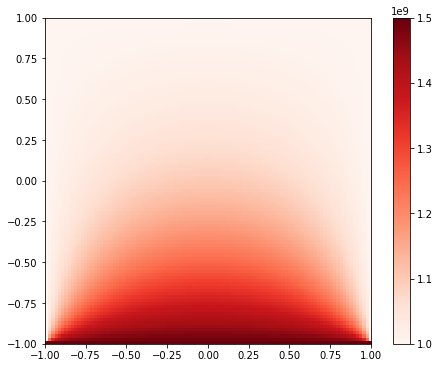

In [69]:
N = 101
M = 10001

print("CD_SPACE_FE_TIME_OPENCL_V1")
print("N: {}".format(N))
print("M: {}".format(M))
print("C: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))

u = np.full((N, N), 1_000_000_000, dtype=np.int64)
v = np.full((N, N), 1_000_000_000, dtype=np.int64)

u[0, :] = 1_500_000_000

finite_differences = FiniteDifferences(N, M)

finite_differences.copy_u_to_device(u)
finite_differences.copy_v_to_device(u)

i = 0

with Timer() as t:
    
    while True:
        finite_differences.step()
        i = i + 1
        temperature = finite_differences.copy_temperature_from_device()
        if not temperature < 1_100_000_000:
            u = finite_differences.copy_v_from_device()            
            break

print("T: {}".format(i / (M - 1)))
print("Total time: {0}".format(t.interval))

plot(u)

### CD_SPACE_RK4_TIME_V0

In [70]:
@njit(parallel=True)
def f(n, u):
    f = np.zeros((n, n), dtype=u.dtype)
    for row in range(1, n - 1):
        for col in prange(1, n - 1):
            f[row, col] = (u[row - 1, col] + u[row + 1, col] + u[row, col - 1] + u[row, col + 1] - 4 * u[row, col]) * (n - 1) * (n - 1) / 4
    return f

@njit
def k1_func(n, m, u):
    return f(n, u) / (m - 1)

@njit
def k2_func(n, m, u, k1):
    return f(n, u + k1 / 2) / (m - 1)

@njit
def k3_func(n, m, u, k2):
    return f(n, u + k2 / 2) / (m - 1)

@njit
def k4_func(n, m, u, k3):
    return f(n, u + k3) / (m - 1)

@njit
def rk4_func(n, m, u):

    k1 = np.zeros((n, n), dtype=u.dtype)
    k2 = np.zeros((n, n), dtype=u.dtype)
    k3 = np.zeros((n, n), dtype=u.dtype)
    k4 = np.zeros((n, n), dtype=u.dtype)
    
    k1 = k1_func(n, m, u)
    k2 = k2_func(n, m, u, k1)
    k3 = k2_func(n, m, u, k2)
    k4 = k2_func(n, m, u, k3)
    
    return u + (k1 + 2 * k2 + 2 * k3 + k4) / 6

CD_SPACE_RK4_TIME_V0
N: 101
M: 10001
C: 0.25
T: 0.424
Total time: 12.21452784538269


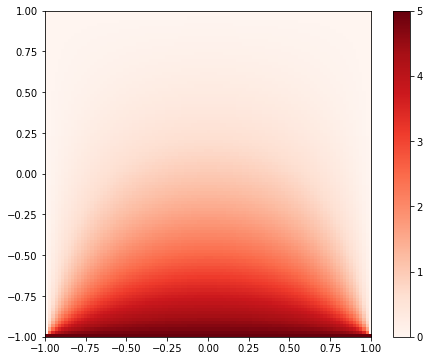

In [71]:
N = 101
M = 10001

print("CD_SPACE_RK4_TIME_V0")
print("N: {}".format(N))
print("M: {}".format(M))
print("C: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))

u = np.zeros((N, N), dtype=np.float64)

u[0, :] = 5.0

i = 0

with Timer() as t:
    while u[(N - 1) // 2, (N - 1) // 2] < 1.0:
        u = rk4_func(N, M, u)
        i = i + 1

print("T: {}".format(i / (M - 1)))
print("Total time: {0}".format(t.interval))

plot(u)

### CD_SPACE_RK4_TIME_V1

In [72]:
@njit
def f(n, m, u, v):
    v[1:N-1, 1:N-1] = (u[0:N-2, 1:N-1] + u[2:N, 1:N-1] + u[1:N-1, 0:N-2] + u[1:N-1, 2:N] - 4 * u[1:N-1, 1:N-1]) * (n - 1) * (n - 1) / 4 / (m - 1)

@njit
def rk4_func(n, m, u):

    k1 = np.zeros((n, n), dtype=u.dtype)
    k2 = np.zeros((n, n), dtype=u.dtype)
    k3 = np.zeros((n, n), dtype=u.dtype)
    k4 = np.zeros((n, n), dtype=u.dtype)
    
    f(n, m, u, k1)
    f(n, m, u + k1 / 2, k2)
    f(n, m, u + k2 / 2, k3)
    f(n, m, u + k3, k4)
    
    return u + (k1 + 2 * k2 + 2 * k3 + k4) / 6

CD_SPACE_RK4_TIME_V1
N: 101
M: 10001
C: 0.25
T: 0.4241
Total time: 2.21528697013855


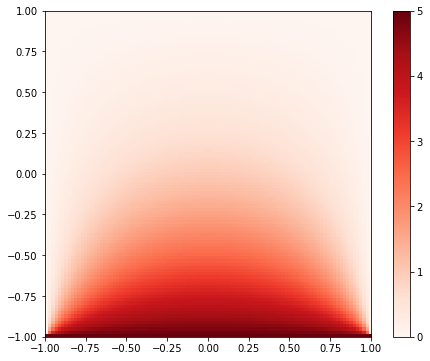

In [73]:
N = 101
M = 10001

print("CD_SPACE_RK4_TIME_V1")
print("N: {}".format(N))
print("M: {}".format(M))
print("C: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))

u = np.zeros((N, N), dtype=np.float64)

u[0, :] = 5.0

i = 0

with Timer() as t:
    
    while u[(N - 1) // 2, (N - 1) // 2] < 1.0:
        u = rk4_func(N, M, u)
        i = i + 1

print("T: {}".format(i / (M - 1)))
print("Total time: {0}".format(t.interval))

plot(u)

### CD_SPACE_RK4_TIME_V1 INT64

In [74]:
@njit
def f(n, m, u, v):
    v[1:N-1, 1:N-1] = (u[0:N-2, 1:N-1] + u[2:N, 1:N-1] + u[1:N-1, 0:N-2] + u[1:N-1, 2:N] - 4 * u[1:N-1, 1:N-1]) * (n - 1) * (n - 1) / 4 / (m - 1)

@njit
def rk4_func(n, m, u):

    k1 = np.zeros((n, n), dtype=u.dtype)
    k2 = np.zeros((n, n), dtype=u.dtype)
    k3 = np.zeros((n, n), dtype=u.dtype)
    k4 = np.zeros((n, n), dtype=u.dtype)
    
    f(n, m, u, k1)
    f(n, m, u + k1 / 2, k2)
    f(n, m, u + k2 / 2, k3)
    f(n, m, u + k3, k4)
    
    return u + (k1 + 2 * k2 + 2 * k3 + k4) / 6

CD_SPACE_RK4_TIME_V1 INT64
N: 101
M: 10001
C: 0.25
T: 0.4241
Total time: 3.798535108566284


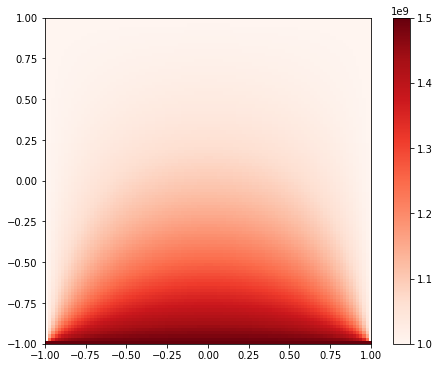

In [75]:
N = 101
M = 10001

print("CD_SPACE_RK4_TIME_V1 INT64")
print("N: {}".format(N))
print("M: {}".format(M))
print("C: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))

u = np.full((N, N), 1_000_000_000, dtype=np.int64)

u[0, :] = 1_500_000_000

i = 0

with Timer() as t:
    
    while u[(N - 1) // 2, (N - 1) // 2] < 1_100_000_000:
        u = rk4_func(N, M, u)
        i = i + 1

print("T: {}".format(i / (M - 1)))
print("Total time: {0}".format(t.interval))

plot(u)

### CD_SPACE_RK4_TIME_OPENCL_V0 INT64

In [76]:
# Define the OpenCL kernel string used in the class FiniteDifference. It is defined here outside
# of the class for readability, and also so that it may be developed/debugged externally and
# easily included here as part of a build system.

kernel_string = """

__kernel void rk4
    (
        const int n, \
        const int m, \
        __global long * restrict u, \
        __global long * restrict v, \
        __global long * restrict k1, \
        __global long * restrict k2, \
        __global long * restrict k3, \
        __global long * restrict k4, \
        __global long * restrict temperature
    )
{
    int r = get_global_id(0);
    int c = get_global_id(1);

    if (r > 0 && r < n - 1 && c > 0 && c < n - 1) {

        k1[n * r + c] = ( \
            ( \
                u[n * (r - 1) + c] + \
                u[n * (r + 1) + c] + \
                u[n * r + (c - 1)] + \
                u[n * r + (c + 1)] - 4 * u[n * r + c] \
            ) * (n - 1) * (n - 1) / 4) / (m - 1);   

        k2[n * r + c] = ( \
            ( \
                u[n * (r - 1) + c] + k1[n * (r - 1) + c] / 2 + \
                u[n * (r + 1) + c] + k1[n * (r + 1) + c] / 2 + \
                u[n * r + (c - 1)] + k1[n * r + (c - 1)] / 2 + \
                u[n * r + (c + 1)] + k1[n * r + (c + 1)] / 2 - 4 * (u[n * r + c] + k1[n * r + c] / 2) \
            ) * (n - 1) * (n - 1) / 4) / (m - 1);

        k3[n * r + c] = ( \
            ( \
                u[n * (r - 1) + c] + k2[n * (r - 1) + c] / 2 + \
                u[n * (r + 1) + c] + k2[n * (r + 1) + c] / 2 + \
                u[n * r + (c - 1)] + k2[n * r + (c - 1)] / 2 + \
                u[n * r + (c + 1)] + k2[n * r + (c + 1)] / 2 - 4 * (u[n * r + c] + k2[n * r + c] / 2) \
            ) * (n - 1) * (n - 1) / 4) / (m - 1);    

        k4[n * r + c] = ( \
            ( \
                u[n * (r - 1) + c] + k3[n * (r - 1) + c] + \
                u[n * (r + 1) + c] + k3[n * (r + 1) + c] + \
                u[n * r + (c - 1)] + k3[n * r + (c - 1)] + \
                u[n * r + (c + 1)] + k3[n * r + (c + 1)] - 4 * (u[n * r + c] + k3[n * r + c]) \
            ) * (n - 1) * (n - 1) / 4) / (m - 1);
            
    }
    
    // Assemble bits...

    v[n * r + c] = u[n * r + c] + (k1[n * r + c] + 2 * k2[n * r + c] + 2 * k3[n * r + c] + k4[n * r + c]) / 6;

    // Export the temperature of the centre of the plate.
    
    if (r == (n - 1) / 2 && c == (n - 1) / 2) {
        temperature[0] = v[n * r + c];
    }

    // Get ready for the next step by copying v to u.

    u[n * r + c] = v[n * r + c];
}

"""


# Define the class.

class RK4CL_V0:
    """
    This class...
    """
    
    def __init__(self, n, m):
        """
        This constructor...
        """
        
        # Store the n and m as instance variables for access by class methods.
        
        self.n = n
        self.m = m
                
        # Create a GPU specific context and command queue.
        
        self.ctx = cl.Context(dev_type = cl.device_type.GPU)
        
        self.queue = cl.CommandQueue(self.ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)
 
        # Create input and output buffers u and v as READ_WRITE because we may read the result from u or v.
 
        self.u = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.int64).itemsize * n * n)
        self.v = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.int64).itemsize * n * n)
        
        # Create buffers to hold the intermediate Runge-Kutta values.
        
        self.k1 = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.int64).itemsize * n * n)
        self.k2 = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.int64).itemsize * n * n)
        self.k3 = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.int64).itemsize * n * n)
        self.k4 = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.int64).itemsize * n * n)
                
        # Create a buffer to hold the current temperature of the centre of the plate.
        
        self.temperature = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.int64).itemsize)

        # Build the kernel.
        
        self.kernel = cl.Program(self.ctx, kernel_string).build().rk4


    def copy_u_to_device(self, u):
        cl.enqueue_copy(self.queue, self.u, u)


    def copy_v_to_device(self, v):
        cl.enqueue_copy(self.queue, self.v, v)


    def copy_k1_to_device(self, k1):
        cl.enqueue_copy(self.queue, self.k1, k1)


    def copy_k2_to_device(self, k2):
        cl.enqueue_copy(self.queue, self.k2, k2)


    def copy_k3_to_device(self, k3):
        cl.enqueue_copy(self.queue, self.k3, k3)


    def copy_k4_to_device(self, k4):
        cl.enqueue_copy(self.queue, self.k4, k4)


    def copy_v_from_device(self):
        v = np.zeros((self.n, self.n), dtype=np.int64)
        cl.enqueue_copy(self.queue, v, self.v)            
        return v


    def copy_temperature_from_device(self):
        temperature = np.zeros((1), dtype=np.int64)
        cl.enqueue_copy(self.queue, temperature, self.temperature)            
        return temperature[0]

           
    def step(self):
        """
        This method...
        """     
        self.kernel(self.queue, (self.n, self.n), None,
            np.int32(self.n),
            np.int32(self.m),
            self.u,
            self.v,
            self.k1,
            self.k2,
            self.k3,
            self.k4,
            self.temperature)

CD_SPACE_RK4_TIME_OPENCL_V0 INT64
N: 101
M: 10001
C: 0.25
T: 0.424
Total time: 3.84273099899292


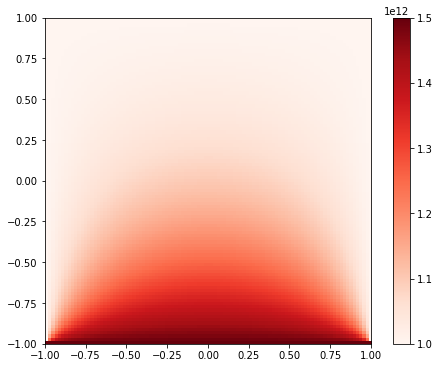

In [77]:
N = 101
M = 10001

print("CD_SPACE_RK4_TIME_OPENCL_V0 INT64")
print("N: {}".format(N))
print("M: {}".format(M))
print("C: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))

u = np.full((N, N), 1_000_000_000_000, dtype=np.int64)

u[0, :] = 1_500_000_000_000

v = np.zeros((N, N), dtype=u.dtype)

k1 = np.zeros((N, N), dtype=u.dtype)
k2 = np.zeros((N, N), dtype=u.dtype)
k3 = np.zeros((N, N), dtype=u.dtype)
k4 = np.zeros((N, N), dtype=u.dtype)

rk4 = RK4CL_V0(N, M)

rk4.copy_u_to_device(u)
rk4.copy_v_to_device(v)

rk4.copy_k1_to_device(k1)
rk4.copy_k2_to_device(k2)
rk4.copy_k3_to_device(k3)
rk4.copy_k4_to_device(k4)

i = 0

with Timer() as t:

    while True:
        rk4.step()
        i = i + 1
        temperature = rk4.copy_temperature_from_device()
        if not temperature < 1_100_000_000_000:
            v = rk4.copy_v_from_device()
            break
        
print("T: {}".format(i / (M - 1)))
print("Total time: {0}".format(t.interval))

plot(v)